## Where are you likely going to travel based on your recent history

## Import the necessary packages

In [1]:
%matplotlib inline
import sys
sys.path.append('/home/xavier/DIR.insight2018/')
from secret import API_KEY, API_SECRET
import flickrapi
import time
import datetime
from calendar import monthrange
import pickle
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
from country_list import countries_for_language
import unidecode # to remove accent on letters
from collections import Counter  # For the histogram
import matplotlib.pyplot as plt # For the histogram
import datapackage # for the list of cities in the world
import re
import scipy.sparse as sps

flickr = flickrapi.FlickrAPI(API_KEY, API_SECRET, format='parsed-json')
#photos = flickr.walk(text='vacation',
#                     tag_mode='all',
#                     tags='cntower',
#                     extras='description,date_upload,date_taken,geo,tags,machine_tags,o_dims,views,url_s,url_m,url_l,url_o',
#                     media='photos',
#                     safe_search=1,
#                     content_type=1,
#                     per_page=50,
#                     has_geo=1,
#                     lat=43.6532,
#                     lon=-79.3832,
#                     radius=10)

#photos.__next__()
#x=photos.__next__()

## Deal with min and max date for the search

In [2]:
def unix_time_month_min(year,month):
    d = datetime.datetime(year,month,1,0,0,1)
    return int(time.mktime(d.timetuple()))
def unix_time_month_max(year,month):
    d = datetime.datetime(year,month,max(monthrange(year, month)),23,59,59)
    return int(time.mktime(d.timetuple()))
# [unix_time_month_min(2015,1),unix_time_month_max(2015,1)]

## Save the raw database to file

In [3]:
def clean_raw_db():
    raw_photos = pd.DataFrame(columns=['datetaken','description','latitude','longitude','owner','place_id','tags','title'])
    return raw_photos

def save_raw(n, raw_photos):
    file_n='raw_photos_'+str(n)+'.plk'
    with open(file_n, 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump(raw_photos, f)
    return

## Gather the entire database -- do not run again!
Load the save file instead

In [ ]:
# max_per_page_flickr = 500
# raw_photos =  clean_raw_db()
# total_comb = 9*10*12*4
# raw_photos = clean_raw_db()
# error_log_call = pd.DataFrame(columns=['keyword','year','month','page'])
# a=0
# startTime = datetime.datetime.now()
# for y in range(2008,2019):
#     for kw in ["travel", "vacation", "vacations", "holidays", "holiday", "travelling", "traveling","trip","sightseeing"]:
#         for m in range(1,13):
#             for pge in range(1,5):
#                 a+=1
#                 try:
#                     x=flickr.photos.search(tags=kw,per_page=max_per_page_flickr,page=pge,
#                                        min_taken_date=unix_time_month_min(y,m),
#                                        max_taken_date=unix_time_month_max(y,m),
#                                        extras='description,date_upload,date_taken,geo,tags')
#                     if len(x['photos']['photo']) > 1:
#                         raw_photos = raw_photos.append(pd.DataFrame(x['photos']['photo'])
#                                    [['datetaken','description','latitude','longitude','owner',
#                                      'place_id','tags','title']],ignore_index=True)
#                     if a % 10 == 0 : 
#                         print(a/total_comb, '  in ', datetime.datetime.now()-startTime)
#                 except:
#                     print('Exception reached in photo', kw, y, m, pge)
#                     error_log_call = error_log_call.append(pd.DataFrame([[kw,y,m,pge]],columns=['keyword','year','month','page']),ignore_index=True)
#                     pass   # This just means continue
#     save_raw(y, raw_photos) # save a different file for every year
#     del raw_photos
#     raw_photos = clean_raw_db()
# print(datetime.datetime.now() - startTime)
# # Roughly 3:30 hours run time

## Save the failed call to the Flickr API -- do not run again

In [4]:
#with open('error_call.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
#    pickle.dump(error_log_call, f)

## Create a list of city and country

In [4]:
def lower_decode(b):
    lower_case = [x.lower() for x in b]
    decoded =  [unidecode.unidecode(x) for x in lower_case]
    return decoded
def country_names():
#    languages = ["en","fr","de","es"]
    languages = ["en"]
    b=[]
    for lang in languages:
        countries = dict(countries_for_language(lang))
        tmp=list(countries.values())
        b+=tmp
    decoded = lower_decode(b)
    return set(decoded)
countries = country_names()

def city_names():
    data_url = 'https://datahub.io/core/world-cities/datapackage.json'

    # to load Data Package into storage
    package = datapackage.Package(data_url)

    # to load only tabular data
    resources = package.resources
    for resource in resources:
        if resource.tabular:
            data = pd.read_csv(resource.descriptor['path'])
#            print (data)
    b=data['name']
    decoded = lower_decode(b)
    return set(decoded)
cities = city_names()

# Remove a few city names because they are confusing: holiday, of, green, panorama
for w in ["holiday", "of", "green", "panorama",'opportunity', 'sunrise', 'paradise', 'man','sunset']:
    cities.remove(w)

## Load the data base one year at the time (cannot load them all - memory limit)
Just load it from below

In [5]:
global_db = clean_raw_db()
global_db["country_text"]=""
global_db["country_GPS"]=""
global_db["city_text"]=""
global_db["city_GPS"]=""
for y in range(2008,2019):
    file_n='raw_photos_'+str(y)+'.plk'
    with open(file_n, 'rb') as f:  # Python 3: open(..., 'wb')
        test = pickle.load(f)

    # Sort the database by owner
    test.sort_values(by=['owner','datetaken'],inplace=True)
    test.reset_index(drop=True,inplace=True)

    # take only one photo per owner per month
    # list of unique owner
    db_unique_owner = clean_raw_db()
    db_unique_owner["country_text"]=""
    db_unique_owner["country_GPS"]=""
    db_unique_owner["city_text"]=""
    db_unique_owner["city_GPS"]=""
    unique_owner = list(set(test['owner']))
#    a=0
    startTime = datetime.datetime.now()
    for owner in unique_owner:
#        a+=1
        db_unique_owner = db_unique_owner.append(test.loc[test['owner']==owner].iloc[0])
#        if a%100 ==0:
#            print(a,len(unique_owner),a/len(unique_owner),datetime.datetime.now() - startTime)
    print(datetime.datetime.now() - startTime)
    db_unique_owner.reset_index(drop=True,inplace=True)
    startTime = datetime.datetime.now()
    for idx in range(len(db_unique_owner)):
        a=[db_unique_owner.iloc[idx][x] for x in ['tags','title','description']][:]
        tmp = a[0]+a[1]+str(list(a[2].values()))
        tmp = re.sub("[^a-z ]+",'',unidecode.unidecode(tmp.lower()))
        tmp = tmp.split(" ")
        tmp = set(tmp)
        matches_country = list(tmp.intersection(countries))
        matches_city = list(tmp.intersection(cities))
        if len(matches_country)  > 0:
            db_unique_owner.loc[idx,'country_text']=max(matches_country, key=len)
        if len(matches_city) > 0:
            db_unique_owner.loc[idx,'city_text']=max(matches_city, key=len)
#        if idx % 100 == 0 : print (idx, ' out of ', len(db_unique_owner), " ", datetime.datetime.now() - startTime)
    #print(test.iloc[idx]['country_text'], test.iloc[idx]['city_text'])
    print(datetime.datetime.now() - startTime)
    #print(len(test))
    file_n='unique_user_'+str(y)+'.plk'
    with open(file_n, 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump(db_unique_owner, f)
    global_db = global_db.append(db_unique_owner, ignore_index=True)
global_db.reset_index(drop=True,inplace=True)
with open('global.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(global_db, f)
# Run time about 1:54 hours

0:09:01.117113
0:02:09.910964
0:08:47.622616
0:02:25.325039
0:10:39.645505
0:02:54.950974
0:08:57.960137
0:02:04.881960
0:08:04.791043
0:02:07.070565
0:08:02.468942
0:02:12.936649
0:07:57.948510
0:02:08.029110
0:07:30.202227
0:01:55.358786
0:06:25.160823
0:01:30.164937
0:05:57.355633
0:01:19.499077
0:02:51.660838
0:00:33.020479


## Load the globalDB from the previous step

In [6]:
with open('global.pkl', 'rb') as f:  # Python 3: open(..., 'wb')
         global_db = pickle.load(f)

## Check the distribution of owner per year
A lot of them ~70 000 are there only once. We need to remove them.

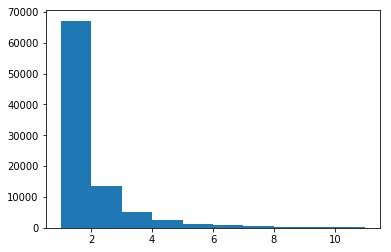

In [7]:
plt.hist(global_db['owner'].value_counts())
type(global_db['owner'].value_counts())
n_years = global_db['owner'].value_counts()
n_years[n_years > 1].index
global_db = global_db[global_db.owner.isin(n_years[n_years > 1].index)]

#n_years['92475540@N00']

(array([13668.,  4997.,  2390.,  1337.,   762.,   461.,   256.,   176.,
          127.,    85.]),
 array([ 2. ,  2.9,  3.8,  4.7,  5.6,  6.5,  7.4,  8.3,  9.2, 10.1, 11. ]),
 <a list of 10 Patch objects>)

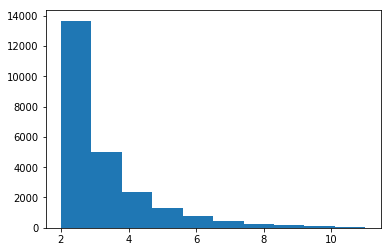

In [8]:
# sanity check - remove all the unique owner
plt.hist(global_db['owner'].value_counts())

## Check how many have tag at either country or city level

In [9]:
global_db[['city_text','country_text']]
print(sum(global_db['city_text'].isnull() & global_db['country_text'].isnull()), ' of ', len(global_db), "don't have either city or country")
print(sum(global_db['city_text'].isnull() ), ' of ', len(global_db), "don't have city")
print(sum(global_db['country_text'].isnull()), ' of ', len(global_db), "don't have country")
print(sum(global_db[global_db['city_text'].isnull()]['latitude'] !=0 ), ' GPS data available for missing city')

16718  of  72208 don't have either city or country
27271  of  72208 don't have city
36749  of  72208 don't have country
6850  GPS data available for missing city


## Fetch the missing city data from the GPS data

In [10]:
GPS_complement = global_db[global_db['city_text'].isnull()]['latitude'] !=0
#global_db.loc[GPS_complement, :]
global_db.loc[GPS_complement.index[GPS_complement],:]
geolocator = Nominatim(user_agent="test_insightToronto")
startTime = datetime.datetime.now()
for idx in GPS_complement.index[GPS_complement]:
    time.sleep(1)
    try:
        location = geolocator.reverse(str((global_db.loc[idx,'latitude']) +"," + str(global_db.loc[idx,'longitude'])),language="en")
#    print(location.address)
    except:
        location=None
        pass
    if location is not None:
        if location.address is not None:
            if 'city' in (location.raw)['address']:
                global_db.loc[idx]['city_GPS'] = unidecode.unidecode(((location.raw)['address']['city']).lower())
            if 'country' in (location.raw)['address']:
                global_db.loc[idx]['country_GPS'] = unidecode.unidecode(((location.raw)['address']['country']).lower())
#    print(global_db.loc[idx]['city_GPS'], global_db.loc[idx]['country_GPS'])
print(datetime.datetime.now() - startTime)
with open('global_GPS.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(global_db, f)
# take roughly 3:35 hours to run

3:42:08.787434


In [11]:
with open('global_GPS.pkl', 'rb') as f:  # Python 3: open(..., 'wb')
         global_db = pickle.load(f)

In [12]:
global_db.reset_index(drop=True,inplace=True)
global_db['w_loc']=""
for idx in range(len(global_db)):
    if pd.isna(global_db.iloc[idx]['city_text']):
        if pd.isna(global_db.iloc[idx]['country_text']):
            if pd.isna(global_db.iloc[idx]['city_GPS']):
                if pd.isna(global_db.iloc[idx]['country_GPS']):
                    global_db.loc[idx]['w_loc']=""
                else:
                    global_db.loc[idx]['w_loc']=global_db.loc[idx]['country_GPS']
            else:
                global_db.loc[idx]['w_loc']=global_db.loc[idx]['city_GPS']
        else:
            global_db.loc[idx]['w_loc']=global_db.loc[idx]['country_text']
    else:
        global_db.loc[idx]['w_loc']=global_db.loc[idx]['city_text']

## Remove those without location

In [13]:
global_db.reset_index(drop=True,inplace=True)
global_db = global_db[global_db.index.isin(  global_db[global_db['w_loc'] !=""].index    )]

## Remove owner with only one travel

In [14]:
global_db.reset_index(drop=True,inplace=True)
n_years = global_db['owner'].value_counts()
n_years[n_years > 1].index
global_db = global_db[global_db.owner.isin(n_years[n_years > 1].index)]

## Sort by owner and date and re-index

In [15]:
global_db.sort_values(by=['owner','datetaken'],inplace=True)
global_db.reset_index(drop=True,inplace=True)

## Create a dictionary with author and sequence of travel place

In [16]:
seq_travel={}
for owner in set(global_db['owner']):
    seq_travel[owner] = list(global_db[global_db['owner'] == owner]['w_loc'])

## Save the dictionary of travel

In [17]:
with open('seq_travel.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(seq_travel, f)

## Load from saved file

In [18]:
with open('seq_travel.pkl', 'rb') as f:  # Python 3: open(..., 'wb')
    seq_travel = pickle.load(f)

In [19]:
# Check which locations appear more often
import operator
flat_list = [item for sublist in list(seq_travel.values()) for item in sublist] # get all destination 
flat_list
def freq(lst):
    d = {}
    for i in lst:
        if d.get(i):
            d[i] += 1
        else:
            d[i] = 1
    return d
d=freq(flat_list)
sorted_x = sorted(d.items(), key=operator.itemgetter(1),reverse=True)
sorted_x

[('asia', 1116),
 ('london', 1046),
 ('italy', 918),
 ('paris', 864),
 ('france', 814),
 ('greece', 776),
 ('mexico', 709),
 ('seaside', 656),
 ('usa', 591),
 ('spain', 576),
 ('orange', 544),
 ('barcelona', 521),
 ('florida', 497),
 ('berlin', 478),
 ('manhattan', 418),
 ('venice', 405),
 ('germany', 398),
 ('washington', 380),
 ('amsterdam', 374),
 ('young', 360),
 ('best', 358),
 ('rome', 338),
 ('bangkok', 334),
 ('golden', 333),
 ('india', 330),
 ('wedding', 330),
 ('bay', 328),
 ('prague', 320),
 ('australia', 318),
 ('central', 313),
 ('thailand', 298),
 ('tokyo', 294),
 ('iceland', 289),
 ('singapore', 286),
 ('istanbul', 257),
 ('united kingdom', 255),
 ('can', 252),
 ('tours', 250),
 ('budapest', 242),
 ('york', 240),
 ('portugal', 234),
 ('chicago', 229),
 ('bali', 229),
 ('nice', 227),
 ('colorado', 222),
 ('japan', 205),
 ('along', 198),
 ('cornwall', 197),
 ('canada', 196),
 ('san', 191),
 ('madrid', 190),
 ('shoreline', 190),
 ('andalucia', 188),
 ('norway', 186),
 ('aus

## Make a large matrix with row of user and column as destination

In [16]:
name_row = list(set(seq_travel.keys())) # get all owner name
flat_list = [item for sublist in list(seq_travel.values()) for item in sublist] # get all destination 
flat_list=set(flat_list) # and remove duplicate destination
mat_rep = sps.coo_matrix((len(name_row), len(flat_list))) # np.full((len(name_row),len(flat_list)), False, dtype=bool)

bool_db_dest = pd.DataFrame(mat_rep, columns=flat_list, index=name_row)
#bool_db_dest.loc[name_row[0],seq_travel(name_row[0])]
startTime = datetime.datetime.now()
for idx in range(1): #range(len(bool_db_dest)):
    print(len(seq_travel[name_row[idx]]))
    
#    a=[bool_db_dest.columns.get_loc(i) for i in seq_travel[name_row[idx]]]
#    print(a)
    bool_db_dest.loc[name_row[idx],seq_travel[name_row[idx]]]=True
print(datetime.datetime.now() -startTime)
#with open('bool_db.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
#    pickle.dump(bool_db_dest, f)
itertools.repeat(0, 4)

2


KeyboardInterrupt: 

ValueError: DataFrame constructor not properly called!

In [194]:



max(GPS_complement.index[GPS_complement])

139191

In [35]:
startTime = datetime.datetime.now()
b=0
for idx in range(len(db_unique_owner)):
    a=[db_unique_owner.iloc[idx][x] for x in ['tags','title','description']][:]
    tmp = a[0]+a[1]+str(list(a[2].values()))
    tmp = re.sub("[^a-z ]+",'',unidecode.unidecode(tmp.lower()))
    tmp = tmp.split(" ")
    tmp = set(tmp)
    matches_country = list(tmp.intersection(countries))
    matches_city = list(tmp.intersection(cities))
    if len(matches_country)  > 0:
        db_unique_owner.loc[idx,'country_text']=matches_country[0]
    if len(matches_city) > 0:
        db_unique_owner.loc[idx,'city_text']=matches_city[0]
    if idx % 100 == 0 : print (idx, ' out of ', len(db_unique_owner), " ", datetime.datetime.now() - startTime)
#print(test.iloc[idx]['country_text'], test.iloc[idx]['city_text'])
print(datetime.datetime.now() - startTime)
#print(len(test))
# slightly above 6 hours to run 

0  out of  14783   0:00:00.017956
100  out of  14783   0:00:01.139880
200  out of  14783   0:00:02.202145
300  out of  14783   0:00:03.140438
400  out of  14783   0:00:04.087971
500  out of  14783   0:00:05.087927
600  out of  14783   0:00:06.074486
700  out of  14783   0:00:07.110898
800  out of  14783   0:00:08.106016
900  out of  14783   0:00:09.168497
1000  out of  14783   0:00:10.095154
1100  out of  14783   0:00:11.017233
1200  out of  14783   0:00:12.087037
1300  out of  14783   0:00:13.137459
1400  out of  14783   0:00:14.218145
1500  out of  14783   0:00:15.284246
1600  out of  14783   0:00:16.501181
1700  out of  14783   0:00:17.518954
1800  out of  14783   0:00:18.578701
1900  out of  14783   0:00:19.594281
2000  out of  14783   0:00:20.548398
2100  out of  14783   0:00:21.463751
2200  out of  14783   0:00:22.400208
2300  out of  14783   0:00:23.563466
2400  out of  14783   0:00:24.453924
2500  out of  14783   0:00:25.564405
2600  out of  14783   0:00:26.605454
2700  out of 

AttributeError: 'float' object has no attribute 'values'

In [38]:
db_unique_owner

,datetaken,description,latitude,longitude,owner,place_id,tags,title,city_text,country_text
0,2008-12-30 13:56:40,{'_content': ''},0,0,77843261@N02,NaN,holiday,100_0006,holiday,NaN
1,2008-07-03 20:53:45,"{'_content': 'Jungle Tour, Thailand'}",0,0,118345905@N07,NaN,travel elephant thailand chiangmai,"IMG_2839 Jungle ,Chiang Mai",NaN,thailand
2,2008-07-31 12:45:40,{'_content': ''},0,0,65100187@N05,NaN,travel sky sun solar eclipse russia space himm...,"Total Solar Eclipse, Russia",NaN,russia
3,2008-07-04 02:26:32,{'_content': ''},0,0,20124241@N00,NaN,christmas holiday tree decorating babyofmine 2011,decking the halls,holiday,NaN
4,2008-11-05 14:52:08,{'_content': ''},0,0,30083550@N04,NaN,travel cambridge travelling victoriano,IMG_0255.JPG,cambridge,NaN
5,2008-07-17 00:55:50,{'_content': 'Burano Italy'},45.486793,12.418413,53928360@N00,gaq6L7dWU7vvREY,1bluecanoe travel color town burano italy ital...,Colorful Burano,NaN,italy
6,2008-05-07 10:25:29,{'_content': ''},0,0,46762729@N03,NaN,holiday animals scotland flickr tablet shetlan...,Puffin,holiday,NaN
7,2008-07-03 17:13:18,{'_content': 'Marcus Brunnmeier'},0,0,14827809@N04,NaN,trip flickr,"glacial esker, Moisie river",NaN,NaN
8,2008-06-29 09:18:30,{'_content': ''},0,0,79033059@N06,NaN,holiday kitchen cottage,Kitchen : Cottage 1,holiday,NaN
9,2008-11-25 17:23:40,{'_content': 'Fur Seal'},0,0,77035272@N07,NaN,furseal newzealand kaikoura holidays 2008nz nz...,2008 11 25_0045_edited-1.jpg,NaN,NaN


In [70]:
# with open('raw_photos_2008.plk', 'rb') as f:  # Python 3: open(..., 'rb')
#     test =  pickle.load(f)
# #test
# # for y in range(2009,2019):
# #     file_n='raw_photos_'+str(y)+'.plk'
# #     with open(file_n, 'rb') as f:  # Python 3: open(..., 'wb')
# #         tmp = pickle.load(f)
# #     long_db = pd.concat([long_db,tmp],ignore_index=True)
# #     print(y)

# test["country_text"]=""
# test["country_GPS"]=""
# test["city_text"]=""
# test["city_GPS"]=""

# #print(list(test.columns.values))
# # Sort the database by owner
# test.sort_values(by=['owner','datetaken'],inplace=True)
# test.reset_index(drop=True,inplace=True)
    

# startTime = datetime.datetime.now()
# b=0
# for idx in range(len(test)):
#     a=[test.iloc[idx][x] for x in ['tags','title','description']][:]
#     tmp = a[0]+a[1]+str(list(a[2].values()))
#     tmp = re.sub("[^a-z ]+",'',unidecode.unidecode(tmp.lower()))
#     tmp = tmp.split(" ")
#     tmp = set(tmp)
#     if idx > 0:
#         if test.loc[(idx-1),'city_text'] in tmp :
#             b+=1
#             print(b, ' over ', idx)
#             test.loc[idx,'country_text']=test.loc[(idx-1),'country_text']
#             test.loc[idx,'city_text']   =test.loc[(idx-1),'city_text']
#         else:
#             matches_country = list(tmp.intersection(countries))
#             matches_city = list(tmp.intersection(cities))
#             if len(matches_country)  == 1:
#                 test.loc[idx,'country_text']=matches_country[0]
#             if len(matches_city) == 1:
#                 test.loc[idx,'city_text']=matches_city[0]
#     else:
#         print(tmp)
#         matches_country = list(tmp.intersection(countries))
#         matches_city = list(tmp.intersection(cities))
#         if len(matches_country)  > 1:
#             test.loc[idx,'country_text']=matches_country[0]
#         if len(matches_city) > 1:
#             test.loc[idx,'city_text']=matches_city[0]
#     if idx % 100 == 0 : print (idx, ' out of ', len(test), " ", datetime.datetime.now() - startTime)
# #print(test.iloc[idx]['country_text'], test.iloc[idx]['city_text'])
# print(datetime.datetime.now() - startTime)
# #print(len(test))
# # slightly above 6 hours to run 

{'pelo', 'caminho', 'passando', 'da', 'ferias', 'vacations', 'netherlandsamsterdamamsterdama', 'de', 'colonia', 'amsterdam', 'holanda', 'interior'}
0  out of  195670   0:00:00.120911
1  over  1
2  over  2
3  over  4
4  over  5
5  over  6
6  over  7
7  over  8
8  over  9
9  over  10
10  over  11
11  over  12
12  over  13
13  over  14
14  over  15
15  over  16
16  over  17
17  over  18
18  over  19
19  over  20
20  over  21
21  over  22
22  over  23
23  over  24
24  over  25
25  over  26
26  over  27
27  over  28
28  over  29
29  over  30
30  over  31
31  over  32
32  over  33
33  over  34
34  over  35
35  over  36
36  over  37
37  over  38
38  over  39
39  over  40
40  over  41
41  over  42
42  over  43
43  over  44
44  over  45
45  over  46
46  over  47
47  over  48
48  over  49
49  over  50
50  over  51
51  over  52
52  over  53
53  over  54
54  over  55
55  over  56
56  over  57
57  over  58
58  over  59
59  over  60
60  over  61
61  over  62
62  over  63
63  over  64
64  over  65
65

535  over  687
536  over  688
537  over  689
538  over  690
539  over  691
540  over  692
541  over  693
542  over  694
543  over  695
544  over  696
545  over  697
546  over  698
547  over  699
548  over  700
700  out of  195670   0:02:29.802527
549  over  701
550  over  702
551  over  703
552  over  704
553  over  705
554  over  706
555  over  707
556  over  708
557  over  709
558  over  710
559  over  711
560  over  712
561  over  713
562  over  714
563  over  715
564  over  716
565  over  717
566  over  718
567  over  719
568  over  720
569  over  721
570  over  722
571  over  723
572  over  724
573  over  725
574  over  726
575  over  727
576  over  728
577  over  729
578  over  730
579  over  731
580  over  732
581  over  733
582  over  734
583  over  735
584  over  736
585  over  737
586  over  738
587  over  739
588  over  740
589  over  741
590  over  742
591  over  743
592  over  744
593  over  745
594  over  746
595  over  747
596  over  748
597  over  749
598  over  750
599

In [68]:
test.loc[0:9,'city_text']

0    amsterdam
1    amsterdam
2    amsterdam
3       munich
4       munich
5       munich
6       munich
7       munich
8       munich
9       munich
Name: city_text, dtype: object

## Focus on pulling country and city from tag, description, and title. 

## Add columns for "country from tag or title", "country from GPS", "city from title or tag", "city from GPS"

In [ ]:
test["country_text"]=""
test["country_GPS"]=""
test["city_text"]=""
test["city_GPS"]=""
#test

In [ ]:

startTime = datetime.datetime.now()
for idx in range(len(test)):
    a=[test.iloc[idx][x] for x in ['tags','title','description']][:]
    #test.iloc[0][['tags','title','description']]
    tmp = a[0]+a[1]+str(list(a[2].values()))
    tmp = re.sub("[^a-z ]+",'',unidecode.unidecode(tmp.lower()))
    tmp = tmp.split(" ")
    tmp = set(tmp)
    matches_country = list(tmp.intersection(countries))
    matches_city = list(tmp.intersection(cities))
    if len(matches_country)  == 1:
        test.loc[idx,'country_text']=matches_country[0]
    if len(matches_city) == 1:
        test.loc[idx,'city_text']=matches_city[0]
    if idx % 100 == 0 : print (idx, ' out of ', len(test), " ", datetime.datetime.now() - startTime)
#print(test.iloc[idx]['country_text'], test.iloc[idx]['city_text'])
print(datetime.datetime.now() - startTime)
#print(len(test))
# slightly above 1:36 minutes of run 

In [2]:
#flickr.people.getInfo(user_id=flickr.people.findByUsername("APHendry1"))
x=flickr.people.findByUsername(username="APHendry1")

In [16]:
x=4
def test_x(x):
    x+=1
    print(x)
test_x(x)
x

5


4

In [3]:
x['user']['nsid']

'83007471@N04'

In [33]:
#pge=1
#max_per_page_flickr = 500
#x=flickr.photos.search(tags="travel",per_page=max_per_page_flickr,page=pge)

In [34]:
#len(x['photos']['photo'])

## Make a list of 20000 owner who use the tag 'travel'

In [43]:
## gave a 502 error
#list_user = {}
#max_per_page_flickr = 500
#for kw in ["travel", "vacation", "vacations", "holidays", "holiday", "travelling", "traveling","trip","sightseeing"]:
#    for y in range(2008,2018):
#        list_user["string{0}".format(y)]=[]
#        for m in range(1,13):
#            for pge in range(1,5):
#                x=flickr.photos.search(tags=kw,per_page=max_per_page_flickr,page=pge,
#                                       min_taken_date=unix_time_month_min(y,m),
#                                       max_taken_date=unix_time_month_max(y,m))
#                for i in range(len(x['photos']['photo'])):
#                    list_user["string{0}".format(y)].append(x['photos']['photo'][i]['owner'])

## I loaded 2008 as a trial year
Now I need to extract the "destination" from either geotag, tag, title.

In [71]:
#test.iloc[31300:31350][['tags','title','description']]
#test[test['latitude']!=0]

## Add columns for "country from tag or title", "country from GPS", "city from title or tag", "city from GPS"

In [23]:
test["country_text"]=""
test["country_GPS"]=""
test["city_text"]=""
test["city_GPS"]=""
#test

## From GPS data

In [6]:
# Be careful -- limit of one request per second, 3600 per hour

geolocator = Nominatim(user_agent="test_insightToronto")
location = geolocator.reverse("-8.336127, 115.658855")
print(location.address)

Small shop, Jalan JI Ketuk Natih, Jemeluk, Bali, 80852, Indonesia


In [12]:
print(len(test[test['latitude']!=0]), ' out of ', len(test), 'have geotag', len(test[test['latitude']!=0])/len(test), "%")

print("This would require", round(len(test[test['latitude']!=0])/3600), ' hours')

66322  out of  195670 have geotag 0.3389482291613431 %
This would require 18  hours


In [25]:
startTime = datetime.datetime.now()
for idx in range(len(test)):
    a=[test.iloc[idx][x] for x in ['tags','title','description']][:]
    #test.iloc[0][['tags','title','description']]
    tmp = a[0]+a[1]+str(list(a[2].values()))
    tmp = re.sub("[^a-z ]+",'',unidecode.unidecode(tmp.lower()))
    tmp = tmp.split(" ")
    tmp = set(tmp)
    matches_country = list(tmp.intersection(countries))
    matches_city = list(tmp.intersection(cities))
    if len(matches_country)  == 1:
        test.loc[idx,'country_text']=matches_country[0]
    if len(matches_city) == 1:
        test.loc[idx,'city_text']=matches_city[0]
    if idx % 100 == 0 : print (idx, ' out of ', len(test), " ", datetime.datetime.now() - startTime)
#print(test.iloc[idx]['country_text'], test.iloc[idx]['city_text'])
print(datetime.datetime.now() - startTime)
#print(len(test))
# slightly above 1:36 minutes of run 

0  out of  195670   0:00:00.247637
100  out of  195670   0:00:08.087067
200  out of  195670   0:00:13.549089
300  out of  195670   0:00:21.991542
400  out of  195670   0:00:33.736916
500  out of  195670   0:00:39.541786
600  out of  195670   0:00:47.090852
700  out of  195670   0:00:56.127498
800  out of  195670   0:01:01.267815
900  out of  195670   0:01:06.890053
1000  out of  195670   0:01:14.228622
1100  out of  195670   0:01:20.093382
1200  out of  195670   0:01:27.107978
1300  out of  195670   0:01:32.206088
1400  out of  195670   0:01:39.444358
1500  out of  195670   0:01:43.253261
1600  out of  195670   0:01:52.484169
1700  out of  195670   0:01:59.497740
1800  out of  195670   0:02:07.204320
1900  out of  195670   0:02:20.362423
2000  out of  195670   0:02:27.574547
2100  out of  195670   0:02:31.645451
2200  out of  195670   0:02:39.828430
2300  out of  195670   0:02:47.511176
2400  out of  195670   0:02:56.685949
2500  out of  195670   0:03:01.727838
2600  out of  195670   0

KeyboardInterrupt: 

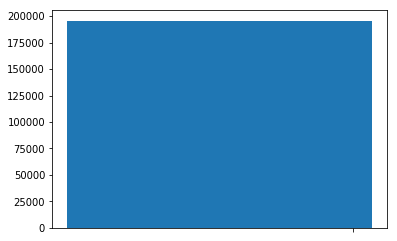

In [273]:
counts = Counter(test['city_text'])

labels, values = zip(*counts.items())

# sort your values in descending order
indSort = np.argsort(values)[::-1]

# rearrange your data
labels = np.array(labels)[indSort]
values = np.array(values)[indSort]

indexes = np.arange(len(labels))

bar_width = 0.35

plt.bar(indexes, values)

# add labels
plt.xticks(indexes + bar_width, labels)
plt.show()

In [274]:
## 
pd.DataFrame(labels, values)

,0
195670,


In [271]:
test['city_text']

0          
1          
2          
3          
4          
5          
6          
7          
8          
9          
10         
11         
12         
13         
14         
15         
16         
17         
18         
19         
20         
21         
22         
23         
24         
25         
26         
27         
28         
29         
         ..
195640     
195641     
195642     
195643     
195644     
195645     
195646     
195647     
195648     
195649     
195650     
195651     
195652     
195653     
195654     
195655     
195656     
195657     
195658     
195659     
195660     
195661     
195662     
195663     
195664     
195665     
195666     
195667     
195668     
195669     
Name: city_text, Length: 195670, dtype: object

In [6]:
with open('userList.plk', 'rb') as f:  # Python 3: open(..., 'rb')
    raw_photos =  pickle.load(f)

## Transform lists to a sorted panda data frame

In [17]:
tmp = {'User': list_user,
       'Month': month,
       'Year': year}
raw_user = pd.DataFrame(tmp)
raw_user.sort_values(by=['User'],inplace=True) # stort the list
raw_user.reset_index(drop=True,inplace=True)
#raw_user

,User,Month,Year
0,100001528@N06,7,2016
1,100001528@N06,7,2016
2,100001528@N06,7,2016
3,100001528@N06,7,2016
4,100001528@N06,7,2016
5,100001528@N06,7,2016
6,100001528@N06,7,2016
7,100001528@N06,7,2016
8,100001930@N07,6,2010
9,100002077@N08,4,2013


## Pick unique users who are present in more than one year


In [20]:
unique_user = {}
#a=0
#startTime = datetime.datetime.now()
# First entry
tmp_user=raw_user['User'][0]
tmp_list_year=[raw_user['Year'][0]]
n_row=len(raw_user['User'])
for i in range(1,n_row): # surf on the list grouped by user faster than doing search df['user'= user]
#    a+=1
    if tmp_user == raw_user['User'][i] :
        tmp_list_year.append(raw_user['Year'][i])
    else:
        set_tmp_list_year = set(tmp_list_year)
        if len(set_tmp_list_year) >1:
            unique_user[tmp_user] = set_tmp_list_year
        # Reset
        tmp_user=raw_user['User'][i]
        tmp_list_year=[raw_user['Year'][i]]
with open('unique_users.plk', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([unique_user], f)
#    if a % 1000 ==0 : print(a/n_row, 'in',  datetime.datetime.now()-startTime)
#set_tmp_list_year = set(tmp_list_year)
#if len(set_tmp_list_year) > 1:
#    unique_user[tmp_user] = set_tmp_list_year
## This is a 1min20 seconds process VS 4 hours for the procedure below

#unique_list = set(raw_user['User'])
#max_usr=len(unique_list)
#for user in unique_list:
#    x=set(raw_user[raw_user['User'] == user]['Year'])
#    length_x = len(x)
#    a +=1
#    if length_x > 1:
#        unique_user.update({'User': i,
#                            'n_years': length_x,
#                            'years': x})
#        
#    if a % 10 ==0 : print(a/max_usr, 'in',  datetime.datetime.now()-startTime)

In [23]:
with open('unique_user.plk', 'rb') as f:  # Python 3: open(..., 'rb')
    unique_user =  pickle.load(f)

In [22]:
raw_user.tail

<bound method NDFrame.tail of                   User  Month  Year
0        100001528@N06      7  2016
1        100001528@N06      7  2016
2        100001528@N06      7  2016
3        100001528@N06      7  2016
4        100001528@N06      7  2016
5        100001528@N06      7  2016
6        100001528@N06      7  2016
7        100001528@N06      7  2016
8        100001930@N07      6  2010
9        100002077@N08      4  2013
10       100002077@N08      4  2013
11       100002077@N08      4  2013
12       100002077@N08      4  2012
13       100002077@N08      4  2012
14       100002077@N08      4  2012
15       100002077@N08      4  2013
16       100002077@N08      4  2013
17       100002797@N05     10  2013
18       100002797@N05     10  2013
19       100005349@N03      5  2015
20       100005349@N03      8  2015
21       100005349@N03      8  2015
22       100005349@N03      8  2015
23       100005349@N03      8  2015
24       100005349@N03      8  2015
25       100005349@N03      8  201

In [16]:
len(list_user)

2000

In [57]:
[len(list_user) , len(set(list_user))]
uniqueUsers=set(list_user)
len(uniqueUsers)

88167

## Save the list of user who use the previous tag

In [116]:
with open('userList.plk', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([list_user,year,month], f)

## Getting back the objects:

In [10]:
with open('userList.plk', 'r') as f:  # Python 3: open(..., 'rb')
   tmp =  pickle.load(f)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

In [24]:
##sandbox
d={}
for x in range(1,10):
        d["string{0}".format(x)]=[]
        

In [25]:
d

{'string1': [],
 'string2': [],
 'string3': [],
 'string4': [],
 'string5': [],
 'string6': [],
 'string7': [],
 'string8': [],
 'string9': []}

In [26]:
d['string1'].append("bye")

In [76]:

list_user

,user,year,month
0,24391862@N06,2017,1
1,134867221@N07,2017,1
2,23985194@N06,2017,1
3,157852789@N03,2017,1
4,86855701@N08,2017,1
5,72616463@N00,2017,1
6,159251252@N07,2017,1
7,159251252@N07,2017,1
8,159251252@N07,2017,1
9,159251252@N07,2017,1


In [112]:
datetime.datetime.now()


datetime.datetime(2018, 9, 16, 22, 59, 37, 856464)

In [106]:
x.append('allo')

In [114]:
list_user

['86423215@N00',
 '141836629@N07',
 '41119009@N00',
 '34690494@N06',
 '159615760@N04',
 '159615760@N04',
 '159615760@N04',
 '159615760@N04',
 '159615760@N04',
 '159615760@N04',
 '159615760@N04',
 '141836629@N07',
 '142710016@N02',
 '142710016@N02',
 '142710016@N02',
 '142710016@N02',
 '141487081@N02',
 '141487081@N02',
 '61456446@N06',
 '61456446@N06',
 '61456446@N06',
 '61456446@N06',
 '61456446@N06',
 '61456446@N06',
 '61456446@N06',
 '61456446@N06',
 '27004296@N03',
 '27964309@N06',
 '159544363@N04',
 '141487081@N02',
 '133926410@N03',
 '7156765@N05',
 '8398907@N02',
 '41119009@N00',
 '41119009@N00',
 '41119009@N00',
 '37041050@N03',
 '48284565@N04',
 '48284565@N04',
 '48489192@N06',
 '48489192@N06',
 '41119009@N00',
 '41119009@N00',
 '41119009@N00',
 '41119009@N00',
 '7156765@N05',
 '21728312@N03',
 '21728312@N03',
 '32852605@N03',
 '41119009@N00',
 '17904502@N00',
 '7156765@N05',
 '145472109@N04',
 '145472109@N04',
 '145472109@N04',
 '144005928@N02',
 '35232195@N06',
 '62887986@N0